# Model 2: Pretrained VGG16

We will use the Pretrained VGG16 directly by adding just an additional fully connected output layer.

In [1]:
### Installing the package required to import functions from notebooks
#!pip install import-ipynb

In [2]:
import import_ipynb
import os
from google.colab import files
files.upload()
os.chdir("/content/drive/MyDrive/Capstone Benchmark Models")

### We will import all the data_preparation functions
from  data_preparation import *


### We will import all visualization functions
from  plots import *

Saving kaggle.json to kaggle (1).json
importing Jupyter notebook from data_preparation.ipynb


Saving kaggle.json to kaggle (6).json
importing Jupyter notebook from plots.ipynb


In [3]:
### Importing necessary libraries

%matplotlib inline


from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras import datasets, layers


## Preparing the Training and Test DataSet

In [4]:
### Dataset is downloaded
download_kaggle()

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 98% 198M/203M [00:01<00:00, 195MB/s]
100% 203M/203M [00:01<00:00, 181MB/s]


In [5]:
### Images are extracted
image_files=image_extract()


In [6]:
### Preparing independent X
X=image_preprocessing_step(image_files,"pretrained_vgg16")

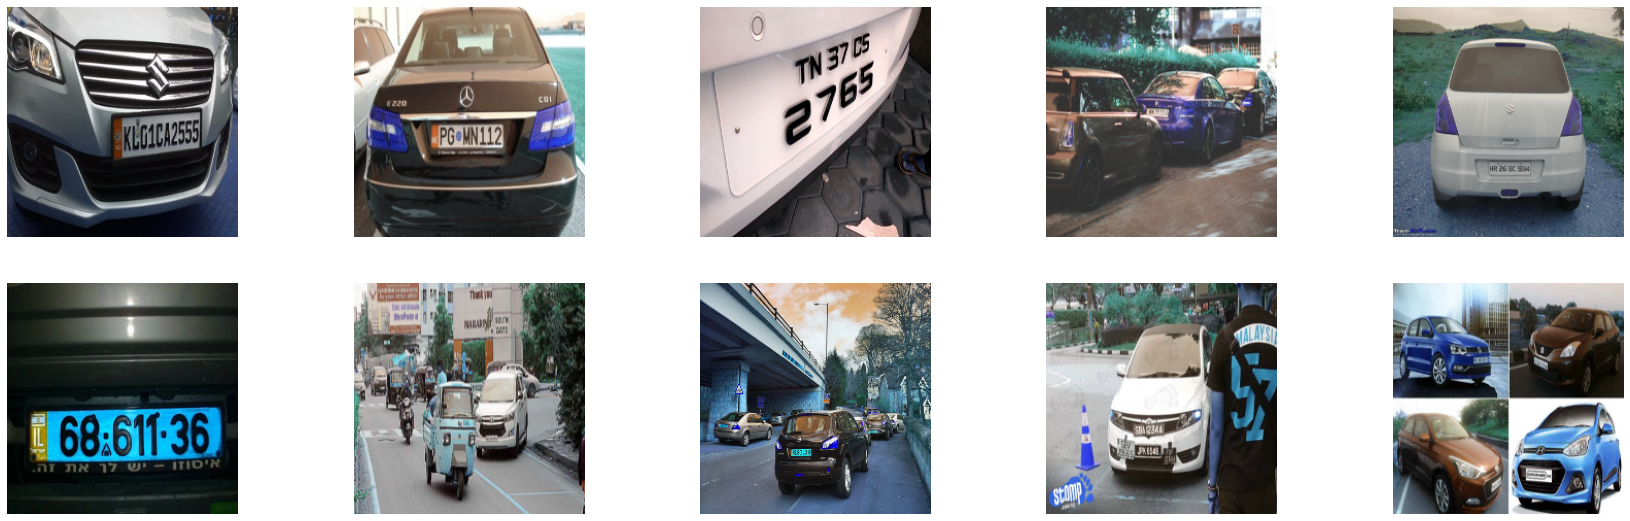

In [7]:
### Showing first 10 images
images_show(10,X)

In [8]:
### Getting a list annotations file

annotations_files=annotations_extract()

In [9]:
### Extracting boundaries from annotations

y=boundary_extract(annotations_files)

In [10]:
### Test train prepartion for 90/10 split
X_train, X_val, y_train, y_val,X_test,y_test=train_test(X,y)


### Model

In [11]:
# Create the model
# We are using VGG16 as a regression model to predict the boundaries of the license plate
# The model has been tuned to optimise validation accuracy

model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(4, activation="sigmoid"))

### We are setting the trainable paramter of VGG16 to False
model.layers[-3].trainable = False


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4)                 100356    
                                                                 
Total params: 14,815,044
Trainable params: 100,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam

checkpoint = ModelCheckpoint('my_model.h5', monitor= 'mse', mode= 'min', save_best_only = True, verbose= 1)
lr_reduce = ReduceLROnPlateau(monitor='mse', factor=0.6, patience=8, verbose=1, mode='min', min_lr=5e-5)

### We are using mean squared error loss function
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['MeanAbsoluteError','mse'])

In [13]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
10/10 [==============================] - 11s 575ms/step - loss: 0.1230 - mean_absolute_error: 0.3058 - mse: 0.1230 - val_loss: 0.0788 - val_mean_absolute_error: 0.2285 - val_mse: 0.0788
Epoch 2/50
10/10 [==============================] - 2s 191ms/step - loss: 0.0786 - mean_absolute_error: 0.2360 - mse: 0.0786 - val_loss: 0.0603 - val_mean_absolute_error: 0.1895 - val_mse: 0.0603
Epoch 3/50
10/10 [==============================] - 2s 195ms/step - loss: 0.0604 - mean_absolute_error: 0.1977 - mse: 0.0604 - val_loss: 0.0549 - val_mean_absolute_error: 0.1813 - val_mse: 0.0549
Epoch 4/50
10/10 [==============================] - 2s 193ms/step - loss: 0.0505 - mean_absolute_error: 0.1700 - mse: 0.0505 - val_loss: 0.0509 - val_mean_absolute_error: 0.1594 - val_mse: 0.0509
Epoch 5/50
10/10 [==============================] - 2s 195ms/step - loss: 0.0445 - mean_absolute_error: 0.1503 - mse: 0.0445 - val_loss: 0.0467 - val_mean_absolute_error: 0.1486 - val_mse: 0.0467
Epoch 6/50
10/10 [=

In [14]:
### Saving the model
model.save('Pretrained_VGG16_model.h5', overwrite=True) 


In [15]:
# Validation dataset performance
scores = model.evaluate(X_test, y_test, verbose=0)
print("The Mean Squared Error : %.2f%%" % (scores[2]*100))
print("The Mean Absolute Error : %.2f%%" % (scores[1]*100))

The Mean Squared Error : 4.92%
The Mean Absolute Error : 15.00%


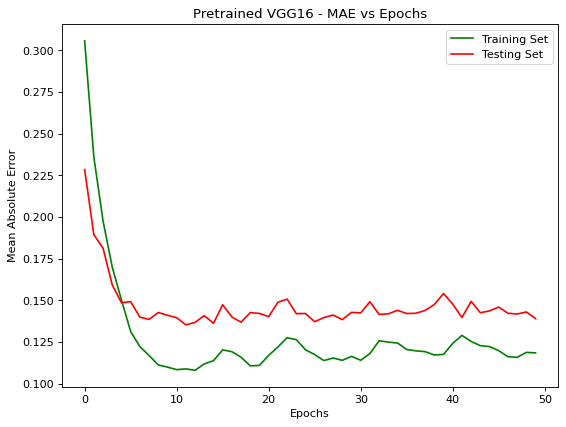

In [16]:
### Plotting Evaluation Function- Mean Absolute Error
plot_scores(train,"Pretrained VGG16")

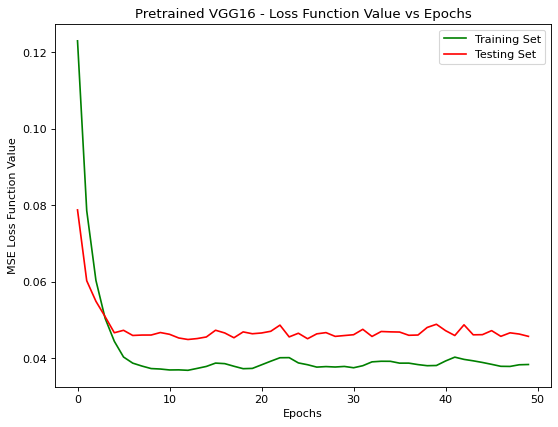

In [17]:
### Plotting Loss Function
plot_loss(train,"Pretrained VGG16")

In [18]:
### Predicting output boundary values
y_cnn = model.predict(X_test)

3/3 [==============================] - 0s 159ms/step


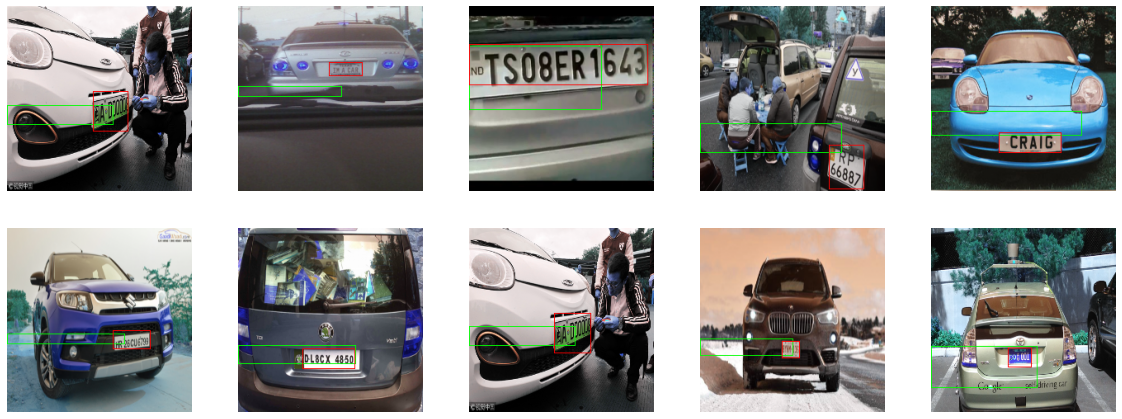

In [19]:
### Plotting the boundaries based on prediction

boundaries(10,y_cnn,y_test,X_test,"/output")